# Grover's Euchre

Here's a implementation of Grover's algorithm to find winning hands in Euchre. 

A euchre deck is shuffled and a right bower is selected to give to the oracle. 
The oracle accepts the right bower suit and then marks the deck for winning hands.

In this case we will consider a 3 card hand.
The winning hand rules are known only to the Oracle:

1. the J of the right bower suit.
2. the J of the opposite suit/same color (left bower)
3. the A/K/Q of the right bower.

### Classical search 

First let's just look at the cards that are high value, the winning cards:
The deck only has 24 cards, and we search to find their positions in a shuffled deck.

In [ ]:
import random

# Define suits, ranks, the Euchre deck, and shuffle it
suits = ['♠', '♥', '♦', '♣']
ranks = ['9', '10', 'J', 'Q', 'K', 'A']
deck = [(rank, suit) for suit in suits for rank in ranks]
random.shuffle(deck)

print("Shuffled Euchre Deck:")
for card in deck:
    print(f"{card[0]}{card[1]}", end='  ')
    
# Suit color groups
same_color = {'♠': '♣', '♣': '♠', '♥': '♦', '♦': '♥'}

# Pick a right bower suit, select left bowers and winning hand
right_bower_suit = random.choice(suits)
left_bower_suit = same_color[right_bower_suit]

winning_cards = [
    ('J', right_bower_suit),
    ('J', left_bower_suit),  
    ('A', right_bower_suit), ('K', right_bower_suit), ('Q', right_bower_suit) 
]

# Linear search for winning card positions
positions = []
for i, (rank, suit) in enumerate(deck):
    if (rank, suit) in winning_cards:
        positions.append((i, f"{rank}{suit}"))

print(f"\nRight Bower Suit Selected: {right_bower_suit}")
print("Winning Hand Cards (positions in deck):")
for pos, card in positions:
    print(f"Position {pos}: {card}")


# Using Grover's Algorithm

Now instead of searching for individual cards in a 24-card deck, lets search the entire set of hands for high-value winning hands.  In this example will only use 3 card hands, so with 24 cards and 3 cards per hand we get a set of size of (24 3) = 2024.  

Consider in this case of Grover's algorithm only the Oracle $f()$ knows the rules of the winning cards. These rules are used to mark a hand's bitstring encoding $x$ such that $f(x)=1$ for a solution and $f(x)=0$ for a non-solution

## Part 1: 

(A)
- Define the deck and methods for encoding and decoding cards and hands.
- Also for reporting create an table where table[hand]=index in the set of all hands.

### Definitions:
- Objects: cards, deck, hands, indexing.
- Methods for encoding, decoding.
- Method for marking bitstrings.

In [1]:
import random
from itertools import combinations
from typing import List, Tuple, Optional

class EuchreDeck:
    SUITS = ['♠', '♥', '♦', '♣']
    RANKS = ['9', '10', 'J', 'Q', 'K', 'A']
    CARDS_PER_HAND = 3
    BITS_PER_CARD = 5
    
    SUIT_BITS = {'♠': '00', '♥': '01', '♦': '10', '♣': '11'}
    RANK_BITS = {'9': '000', '10': '001', 'J': '010', 'Q': '011', 'K': '100', 'A': '101'}
    SAME_COLOR = {'♠': '♣', '♣': '♠', '♥': '♦', '♦': '♥'}

    rank_bitsize = len(RANK_BITS['9'])
    suit_bitsize = len(SUIT_BITS['♠'])
    
    # two dicts for reverse decoding
    INV_SUIT_BITS = {v: k for k, v in SUIT_BITS.items()}
    INV_RANK_BITS = {v: k for k, v in RANK_BITS.items()}

    def __init__(self, seed=42):
        """ shuffled deck and all possible hands """
        random.seed(seed)
        self.deck = [(rank, suit) for suit in self.SUITS for rank in self.RANKS]
        random.shuffle(self.deck)
        self.all_hands = list(combinations(self.deck, self.CARDS_PER_HAND))
        self.hand_indices = {
            tuple(sorted(hand)): idx
            for idx, hand in enumerate(self.all_hands)
        }

    def encode_card(self, rank: str, suit: str) -> str:
        """ encode card into bitstring represntation """
        return self.RANK_BITS[rank] + self.SUIT_BITS[suit]

    def encode_hand(self, hand: List[Tuple[str, str]]) -> List[str]:
        """ encode hand into bitstring represntation """
        return [self.encode_card(r, s) for r, s in hand]

    def decode_card(self, bits: str) -> Optional[Tuple[str, str]]:
        """ For reporting: given a card bitstring, give the decoded view """
        rank_part = bits[:3]
        suit_part = bits[3:5]
        rank = self.INV_RANK_BITS.get(rank_part)
        suit = self.INV_SUIT_BITS.get(suit_part)
        return (rank, suit) if rank and suit else None

    def decode_hand(self, bitstring: str) -> Optional[Tuple[Tuple[str, str], ...]]:
        """ For reporting: given a hand bitstring, give the decoded view """
        cards = [
            self.decode_card(bitstring[i:i + self.BITS_PER_CARD])
            for i in range(0, self.BITS_PER_CARD * self.CARDS_PER_HAND, self.BITS_PER_CARD)
        ]
        return tuple(cards) if all(cards) else None

    def find_hand_index(self, target_hand: List[Tuple[str, str]]) -> Optional[int]:
        """ For reporting: given a hand tuple, find the index in the deck """
        return self.hand_indices.get(tuple(sorted(target_hand)))


In [2]:
deck = EuchreDeck()
pos = 42
hand = deck.all_hands[pos]
encoded = deck.encode_hand(hand)
bitstring = ''.join(encoded)
decoded = deck.decode_hand(bitstring)
index = deck.find_hand_index(hand)

print(f"Length of all hands: {len(deck.all_hands)}")
print(f"Hand #{pos}: {hand}")
print(f"Encoded: {encoded}")
print(f"Bitstring: {bitstring}")
print(f"Decoded: {decoded}")
print(f"Index in all_hands: {index}")


Length of all hands: 2024
Hand #42: (('Q', '♦'), ('9', '♣'), ('J', '♣'))
Encoded: ['01110', '00011', '01011']
Bitstring: 011100001101011
Decoded: (('Q', '♦'), ('9', '♣'), ('J', '♣'))
Index in all_hands: 42


### Part 1 cont'd: 

(B)) 
- Define method to mark winning hands for QuantumCircuit oracle creation.
- Define method to create logical formulas for PhaseOracle creation

In [3]:

def high_hands_bitstrings(trump: str, deck: EuchreDeck) -> list[str]:
    """
    Generate list of bitstrings for high hands for a certain trump.
    e.g. for hearts we have these hands: 
    1: (('J', '♥'), ('J', '♦'), ('A', '♥'))
    2: (('J', '♥'), ('J', '♦'), ('K', '♥'))
    3: (('J', '♥'), ('J', '♦'), ('Q', '♥'))
    bitstrings =>
    ['010010101010101', '010010101010001', '010010101001101']
    """
    left = deck.SAME_COLOR[trump]
    right_bower = deck.encode_card('J', trump)
    left_bower = deck.encode_card('J', left)
    high_trumps = [deck.encode_card(rank, trump) for rank in ['A', 'K', 'Q']]
    
    high_hands = []  
    for high in high_trumps:
        hand = right_bower + left_bower + high  
        high_hands.append(hand) 
    return high_hands

def bitstrings_to_formula(bitstrings: list[str]) -> str:
    """
    Convert bitstring list to logical formula. Use with PhaseOracle.
    e.g 
    convert bitstring list ["101...", "010...", ...] 
    to logical formula string: (q0 & ~q1 & q2 & ...) | (~q3 & q4 & ~q5 & ...) | (...)
    """
    terms = []
    for bstring in bitstrings:
        bits = []
        for idx, bit in enumerate(bstring):
            t = '' if bit == '1' else '~'
            bits.append(f'{t}q{idx}')
        term = '(' + ' & '.join(bits) + ')'
        terms.append(term)

    formula = ' | '.join(terms)
    return formula


In [4]:
deck = EuchreDeck(seed=25)
hand = high_hands_bitstrings('♦', deck)
print(hand)
print(deck.decode_hand(hand[0]))
print(deck.decode_hand(hand[1]))
print(deck.decode_hand(hand[2]))


['010100100110110', '010100100110010', '010100100101110']
(('J', '♦'), ('J', '♥'), ('A', '♦'))
(('J', '♦'), ('J', '♥'), ('K', '♦'))
(('J', '♦'), ('J', '♥'), ('Q', '♦'))


## Part 2: 
### The Oracle:
- Convert bitstrings to logical formula for PhaseOracle creation method.
- Use bitstrings directly for QuantumCircuit creation method.

In [5]:

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZGate, MCMTGate
from qiskit.circuit.library.phase_oracle import PhaseOracle
from typing import Union

def grover_oracle(marked_bitstrings: list[str], 
                  phase_oracle: bool = False) -> Union[PhaseOracle,QuantumCircuit]:
    """ 
    Given marked bitstrings create Grover's oracle:
    - PhaseOracle or QuantumCircuit 
    """
    reverse_marked = [hand[::-1] for hand in marked_bitstrings]  # Qiskit has reversed bit ordering 
    if phase_oracle:
        logical_formula = bitstrings_to_formula(reverse_marked)
        return PhaseOracle(logical_formula)
    else:
        n = len(marked_bitstrings[0])
        qc = QuantumCircuit(n)
        for bstring in reverse_marked:
            indices = [i for i, b in enumerate(bstring) if b == '0']
            qc.x(indices)  # Flip zeroes to ones
            qc.compose(MCMTGate(ZGate(), n - 1, 1), inplace=True)
            qc.x(indices)  # Flip back
        return qc

## Part 4:
### Build and Run Simulation:
- Initialize deck, and create Oracle, create GroverOperator
- Calculate Optimal Iteration count
- Build the circuit
- Run Simulation
- Plot result distribution

Optimal iterations      : 82
Demonstration iterations: 10
Iterations used this run: 10

High Value Euchre Hands, Index, Probability
J♦ J♥ A♦ @ 1235 P(0.01953125)
J♦ J♥ K♦ @ 1474 P(0.0185546875)
J♦ J♥ Q♦ @ 144 P(0.017578125)
K♦ K♥ K♦ @ None P(0.001953125)
A♥ J♣ A♦ @ 1223 P(0.001953125)
Q♦ K♣ 9♣ @ 35 P(0.001953125)
Q♣ 9♥ Q♥ @ 1804 P(0.001953125)
A♥ 9♦ J♥ @ 1394 P(0.001953125)
A♥ J♥ 10♠ @ 1382 P(0.001953125)
J♣ K♥ Q♦ @ 99 P(0.0009765625)
A♣ J♦ A♣ @ None P(0.0009765625)


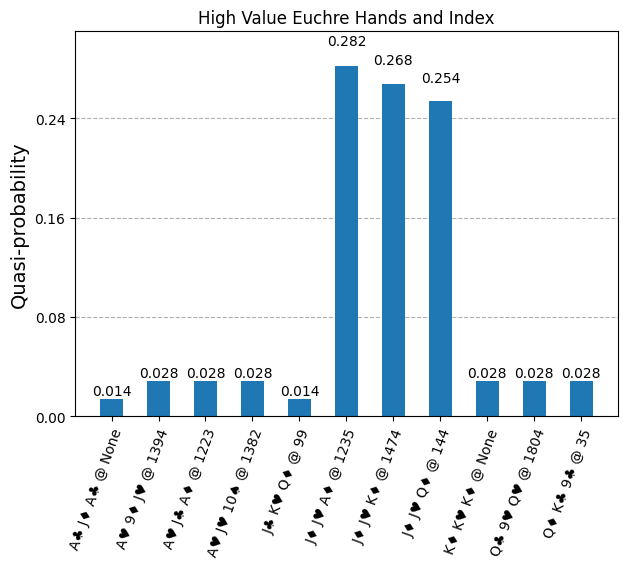

In [9]:

import math
from qiskit.circuit.library import GroverOperator
from qiskit_aer.primitives import Sampler
from qiskit.visualization import plot_distribution
from collections import OrderedDict

# Initialization of deck, mark winning, create oracle and operator.
deck = EuchreDeck()
trump = '♦'
marked = high_hands_bitstrings(trump, deck)
the_oracle = grover_oracle(marked_bitstrings=marked, phase_oracle=True) 
grover_op = GroverOperator(the_oracle)
# the_oracle.draw(output="mpl")

# Determine qubits and optimal number of iterations
n_qubits = len(marked[0])
num_solutions = len(marked)
optimal_iters_theory = math.floor(
    math.pi / (4 * math.asin(math.sqrt(num_solutions / 2**n_qubits)))
)
optimal_iters_demo = 10 # Set for demonstration
optimal_iters = optimal_iters_demo

print(f"Optimal iterations      : {optimal_iters_theory}")
print(f"Demonstration iterations: {optimal_iters_demo}")
print(f"Iterations used this run: {optimal_iters}")

# Build the full Grover circuit
qc = QuantumCircuit(n_qubits)
qc.h(range(n_qubits))  # Create equal superposition
qc.compose(grover_op.power(optimal_iters), inplace=True)  # Set iterations
qc.measure_all()

# Simulation
sampler = Sampler()
sampler.options.default_shots = 1024
result = sampler.run([qc]).result()

# Process results and plot distribution
print("\nHigh Value Euchre Hands, Index, Probability")
dist = result.quasi_dists[0]
top = OrderedDict(sorted(dist.items(), key=lambda x: -x[1])[:20])
decoded_top = {}
for k, v in top.items():
    # for simulator we convert from integer
    # for IBM Quantum it is big-endian bitstring
    if isinstance(k, int):
        bitstring = format(k, f"0{n_qubits}b")
    else:
        bitstring = k[::-1]
        
    hand = deck.decode_hand(bitstring)
    if hand:
        index = deck.find_hand_index(hand)
        hand_str = ' '.join([rank + suit for rank, suit in hand])
        label = f"{hand_str} @ {index}"
        print(label, f"P({v})")
        decoded_top[label] = v
        
plot_distribution(decoded_top, title="High Value Euchre Hands and Index")

## Part 5:
### Build and Run on IBM Quantum:
- setup account, service, backend
- Initialize deck, and create Oracle 
- Calculate Optimal Iteration count
- Build the circuit
- Transpile circuit
- Run on backend
- Plot result distribution  

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, IBMAccountError, Batch, SamplerV2 as Sampler
from qiskit import transpile, QuantumCircuit
from qiskit.circuit.library import GroverOperator
from qiskit.providers.jobstatus import JobStatus
from qiskit.visualization import plot_distribution
from collections import OrderedDict
import math
import dotenv
import os

# Key/Account setup
print("Key/Account setup...")
dotenv.load_dotenv()
quantum_key = os.getenv('IBM_QUANTUM_KEY')
if not quantum_key:
    raise EnvironmentError("IBM_QUANTUM_KEY not found")
try: 
    service = QiskitRuntimeService(channel="ibm_quantum")
    print("Channel found: 'ibm_quantum'")
    
except IBMAccountError as e:
    print(f"Qiskit message: {e}\n...Creating channel 'ibm_quantum'")
    QiskitRuntimeService.save_account(token=quantum_key, channel="ibm_quantum")
    service = QiskitRuntimeService(channel="ibm_quantum")


deck = EuchreDeck()
trump = '♦'
marked = high_hands_bitstrings(trump, deck)
the_oracle = grover_oracle(marked_bitstrings=marked, phase_oracle=True) 
grover_op = GroverOperator(the_oracle)
# the_oracle.draw(output="mpl")

# Determine qubits and optimal number of iterations
n_qubits = len(marked[0])
num_solutions = len(marked)
optimal_iters_theory = math.floor(
    math.pi / (4 * math.asin(math.sqrt(num_solutions / 2**n_qubits)))
)
optimal_iters_demo = 2 # Set for demonstration
optimal_iters = optimal_iters_demo

print(f"Optimal iterations      : {optimal_iters_theory}")
print(f"Demonstration iterations: {optimal_iters_demo}")
print(f"Iterations used this run: {optimal_iters}")

# To run on hardware, select the backend with the fewest number of jobs in the queue
print("Select backend...")
backend = service.least_busy(min_num_qubits=n_qubits, operational=True, simulator=False)
print(f"Backend selected: {backend.name} qubits=({backend.num_qubits}")

# Build the full Grover circuit
qc = QuantumCircuit(n_qubits)
qc.h(range(n_qubits))  # Create equal superposition
qc.compose(grover_op.power(optimal_iters), inplace=True)  # Set iterations
qc.measure_all()

# Transpile circuit for backend
print("Transpiling....")
transpiled_qc = transpile(qc, backend=backend, optimization_level=3)
print("Transpiling complete")

# Use backend sampler for real execution
print("Running job....")
with Batch(backend=backend):
    sampler = Sampler()
    job = sampler.run([transpiled_qc], shots=1024)    
job.wait_for_final_state()
print("Job run complete")

result = job.result()    
dist = result[0].data.meas.get_counts()

# Decode and display results
print("\nResults from real backend:")
top = OrderedDict(sorted(dist.items(), key=lambda x: -x[1])[:20])
decoded_top = {}
for k, v in top.items():
    # for simulator we convert from integer
    # for IBM Quantum it is big-endian bitstring
    if isinstance(k, int):
        bitstring = format(k, f"0{n_qubits}b")
    else:
        bitstring = k[::-1]
        
    hand = deck.decode_hand(bitstring)
    if hand:
        index = deck.find_hand_index(hand)
        hand_str = ' '.join([rank + suit for rank, suit in hand])
        label = f"{hand_str} @ {index}"
        print(label, f"P({v})")
        decoded_top[label] = v

plot_distribution(decoded_top, title=f"Grover Result on {backend.name}")